In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")


In [28]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command
import os
from langchain_anthropic import ChatAnthropic


members = ["english speeaker", "french speeaker"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH. If the are more then 3 exchange response FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


# llm_english = ChatOpenAI(base_url=os.environ.get("SCW_GENERATIVE_APIs_ENDPOINT"),api_key=os.environ.get("SCW_SECRET_KEY_PERSO"),model="llama-3.1-70b-instruct")
# llm_french = ChatOpenAI(base_url=os.environ.get("SCW_GENERATIVE_APIs_ENDPOINT"),api_key=os.environ.get("SCW_SECRET_KEY_PERSO"),model="llama-3.1-8b-instruct")


llm_english = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm_french = ChatAnthropic(model="claude-3-5-sonnet-latest")

class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm_english.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [29]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


english_agent = create_react_agent(
    llm_english, tools=[]
)


def worker_english(state: State) -> Command[Literal["supervisor"]]:
    result = english_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
french_agent = create_react_agent(llm_french, tools=[])


def worker_french(state: State) -> Command[Literal["supervisor"]]:
    result = french_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("english speeaker", worker_english)
builder.add_node("french speeaker", worker_french)
graph = builder.compile()

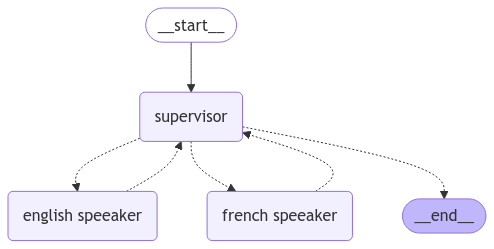

In [30]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
for s in graph.stream(
    {"messages": [("user", "Donne moi une question de culture general rédigé en anglais sans la reponse. Puis repond en Francais.")]},
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'english speeaker'}})
----
(('english speeaker:086bd94c-ada5-1f22-3355-db15298d1316',), {'agent': {'messages': [AIMessage(content="Question (en anglais):\nWhich ancient civilization built the famous city of Petra, carved into pink sandstone cliffs, which is now located in modern-day Jordan?\n\nRéponse (en français):\nLes Nabatéens ont construit la cité de Petra aux alentours du VIe siècle avant J.-C. Ce peuple arabe était composé de commerçants et d'architectes talentueux qui ont créé cette ville impressionnante en la sculptant directement dans la roche rose. Petra était un important centre commercial situé au carrefour des routes de la soie et des épices. La cité a été redécouverte par l'explorateur suisse Johann Ludwig Burckhardt en 1812.", additional_kwargs={}, response_metadata={'id': 'msg_01DzSRBAcWzutQoAUb1Ah4iG', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache